In [1]:
import polars as pl
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import lnglat_to_meters
import colorcet as cc
import numpy as np
from IPython.display import display

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="datashader")

# Where are our datapoints?
Do we have good coverage of the whole globe? Are we missing key places? Are there any suspicious patterns or gaps?

In [2]:
# Load the data
df = pl.read_csv("../data/clustered_coords.csv")
df = df.select(["lon", "lat", "cluster"])

# mercator projection
df = df.drop_nulls(subset=["lon", "lat"]).filter(pl.col("lon").is_not_nan() & pl.col("lat").is_not_nan())
df = df.with_columns([
    pl.struct([pl.col("lon"), pl.col("lat")])
    .map_elements(lambda s: lnglat_to_meters(s["lon"], s["lat"]), return_dtype=pl.List(pl.Float64))
    .alias("coords")
]).with_columns([
    pl.col("coords").list.get(0).alias("x"),
    pl.col("coords").list.get(1).alias("y")
]).select(["x", "y", "cluster"])

In [73]:
df.group_by(["cluster"]).agg(pl.count()).sort("count", descending=True)

/tmp/ipykernel_13767/902555055.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  df.group_by(["cluster"]).agg(pl.count()).sort("count", descending=True)


cluster,count
i64,u32
-1,2916273
121215,10274
667,4378
20478,3874
33066,3464
…,…
121360,5
19123,5
87809,5


In [3]:
x_range = (df["x"].min(), df["x"].max())
y_range = (-8723970.  81755283, 11723970.81755283)

buffer = (x_range[1] - x_range[0]) * 0.02  # 2% buffer
x_range = (x_range[0] - buffer, x_range[1] + buffer)
y_range = (y_range[0] - buffer, y_range[1] + buffer)

In [4]:
pandas_df = df.select(["x", "y", "cluster"]).to_pandas()

pandas_df.dropna(subset=['x', 'y'], inplace=True)
pandas_df = pandas_df[(~np.isinf(pandas_df['x'])) & (~np.isinf(pandas_df['y']))]

pandas_df['x'] = pandas_df['x'].astype(float)
pandas_df['y'] = pandas_df['y'].astype(float)

pandas_df['cluster'] = pandas_df['cluster'].astype('category')

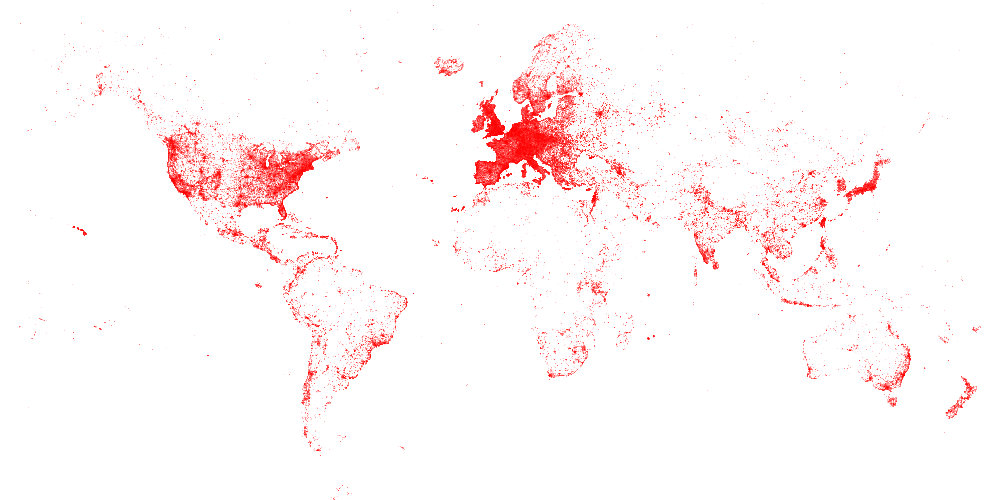

In [10]:
# Try rendering the test subset
canvas = ds.Canvas(plot_width=1000, plot_height=500, x_range=x_range, y_range=y_range)
agg = canvas.points(pandas_df, 'x', 'y', ds.count())
img = tf.shade(agg, cmap=['white', 'red'])
display(img.to_pil())

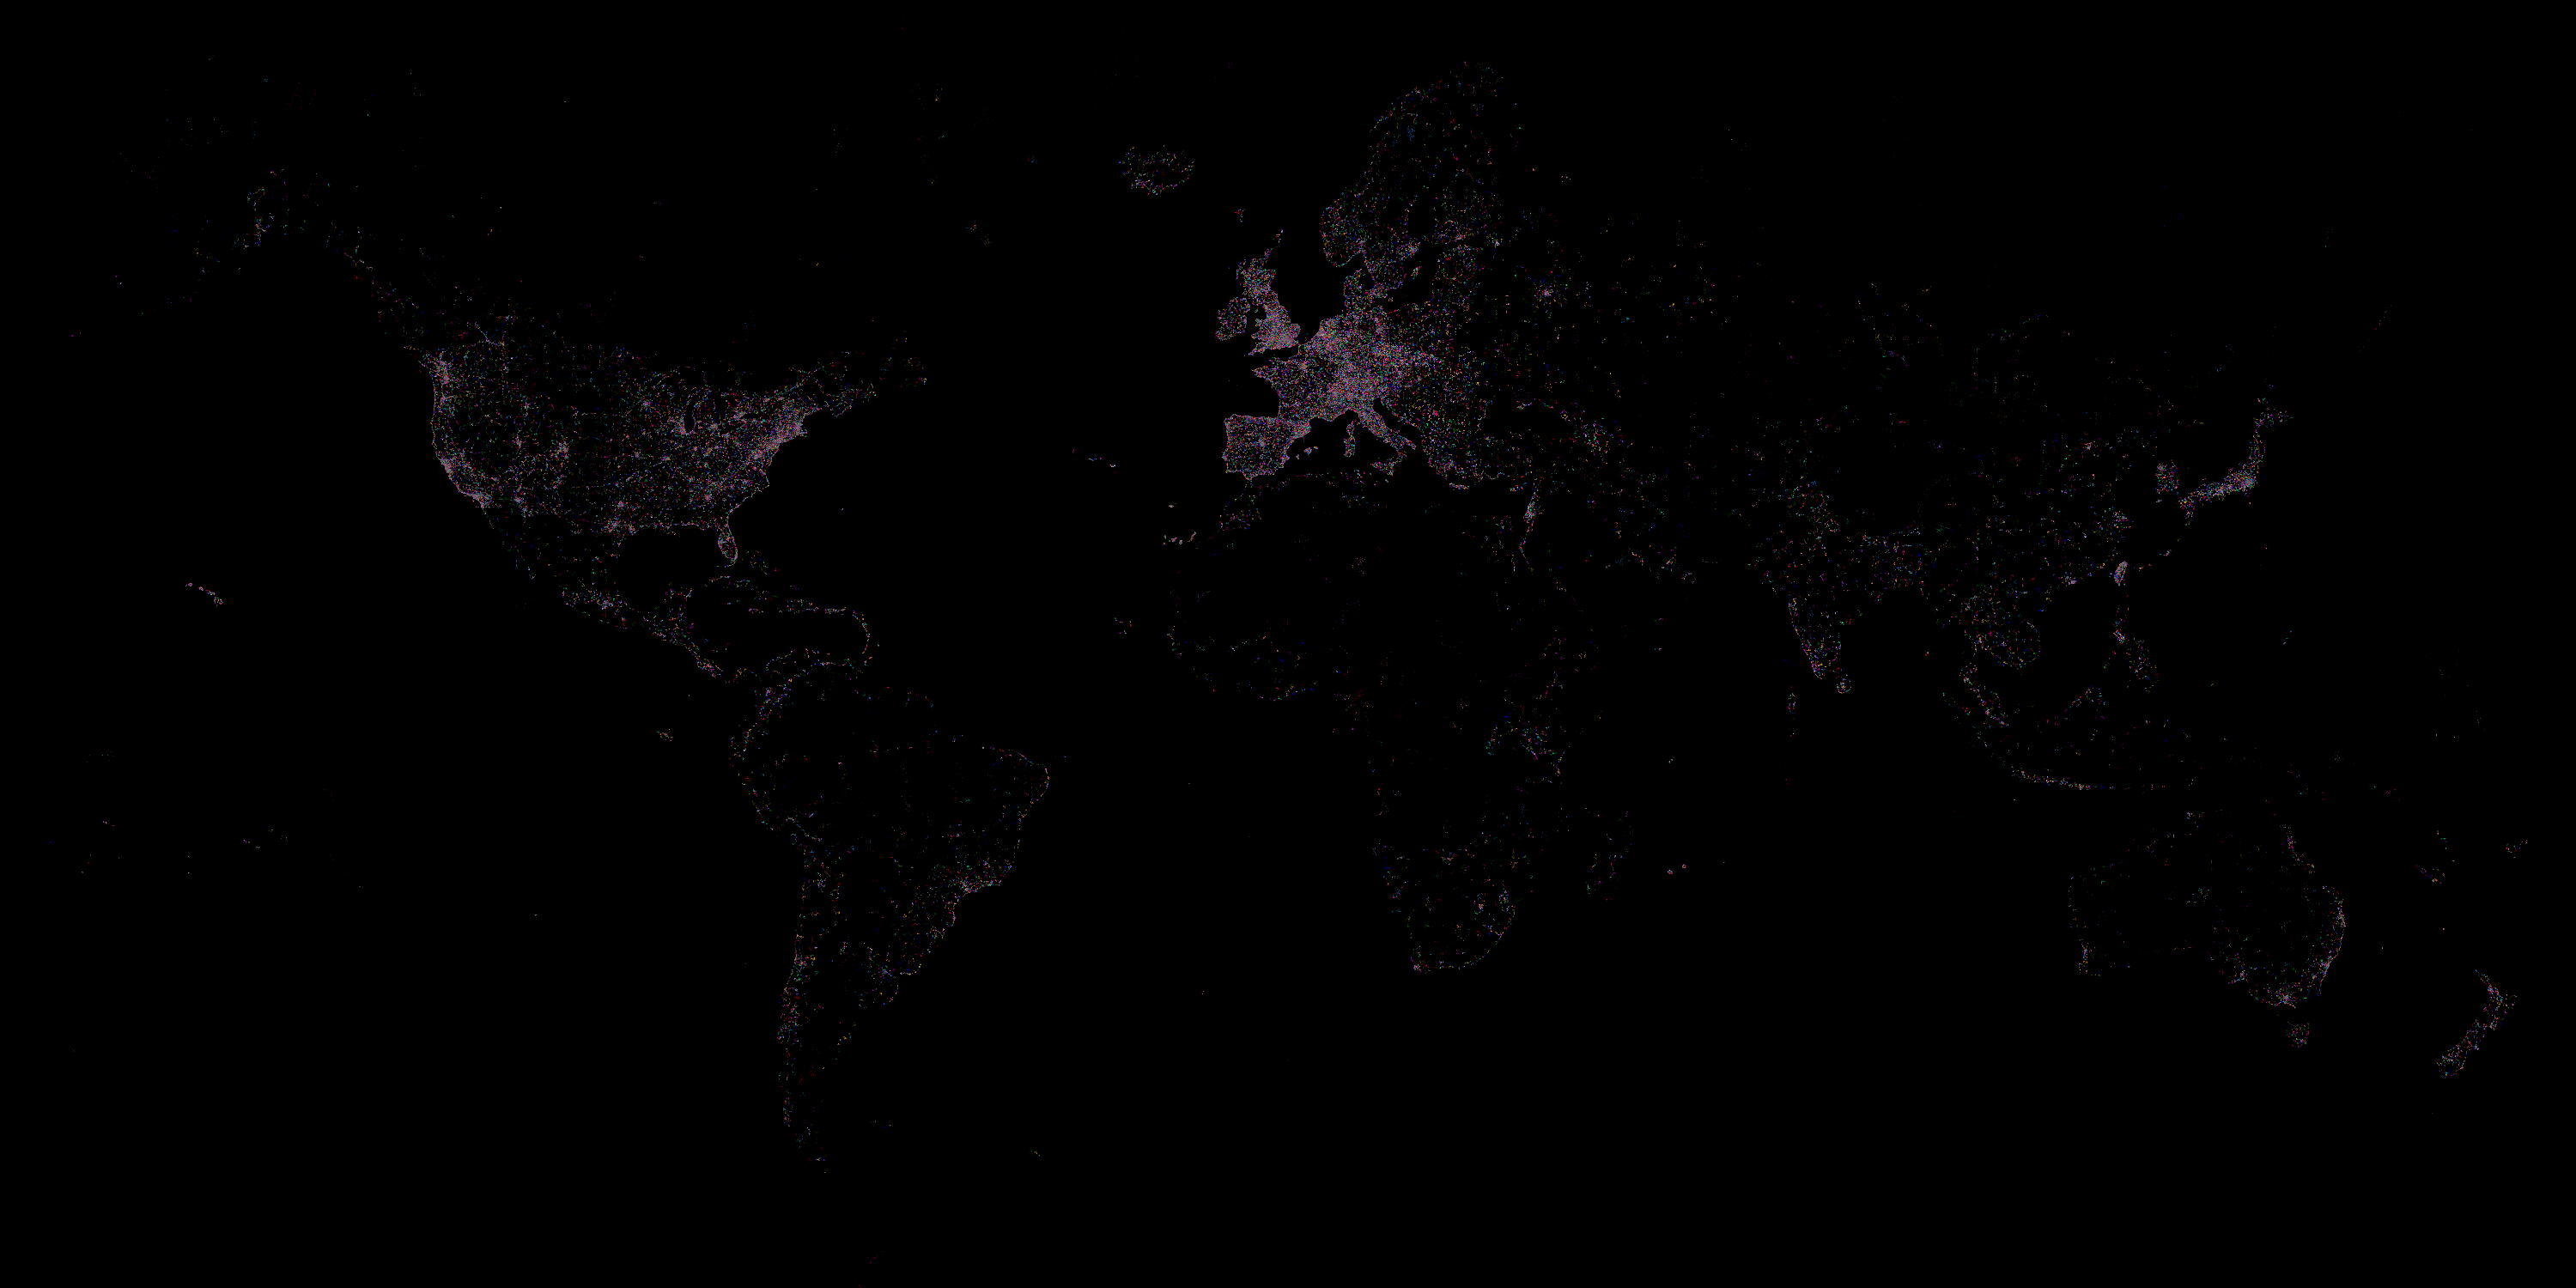

In [62]:
# Color by cluster
# waaaayy too many clusters, so apply modulo to reduce to 22
reduced_clusters = pandas_df.copy()
reduced_clusters = reduced_clusters[reduced_clusters['cluster'].astype('int') > 0]
reduced_clusters['cluster'] = reduced_clusters['cluster'].cat.codes % 22
reduced_clusters['cluster'] = reduced_clusters['cluster'].astype('category')

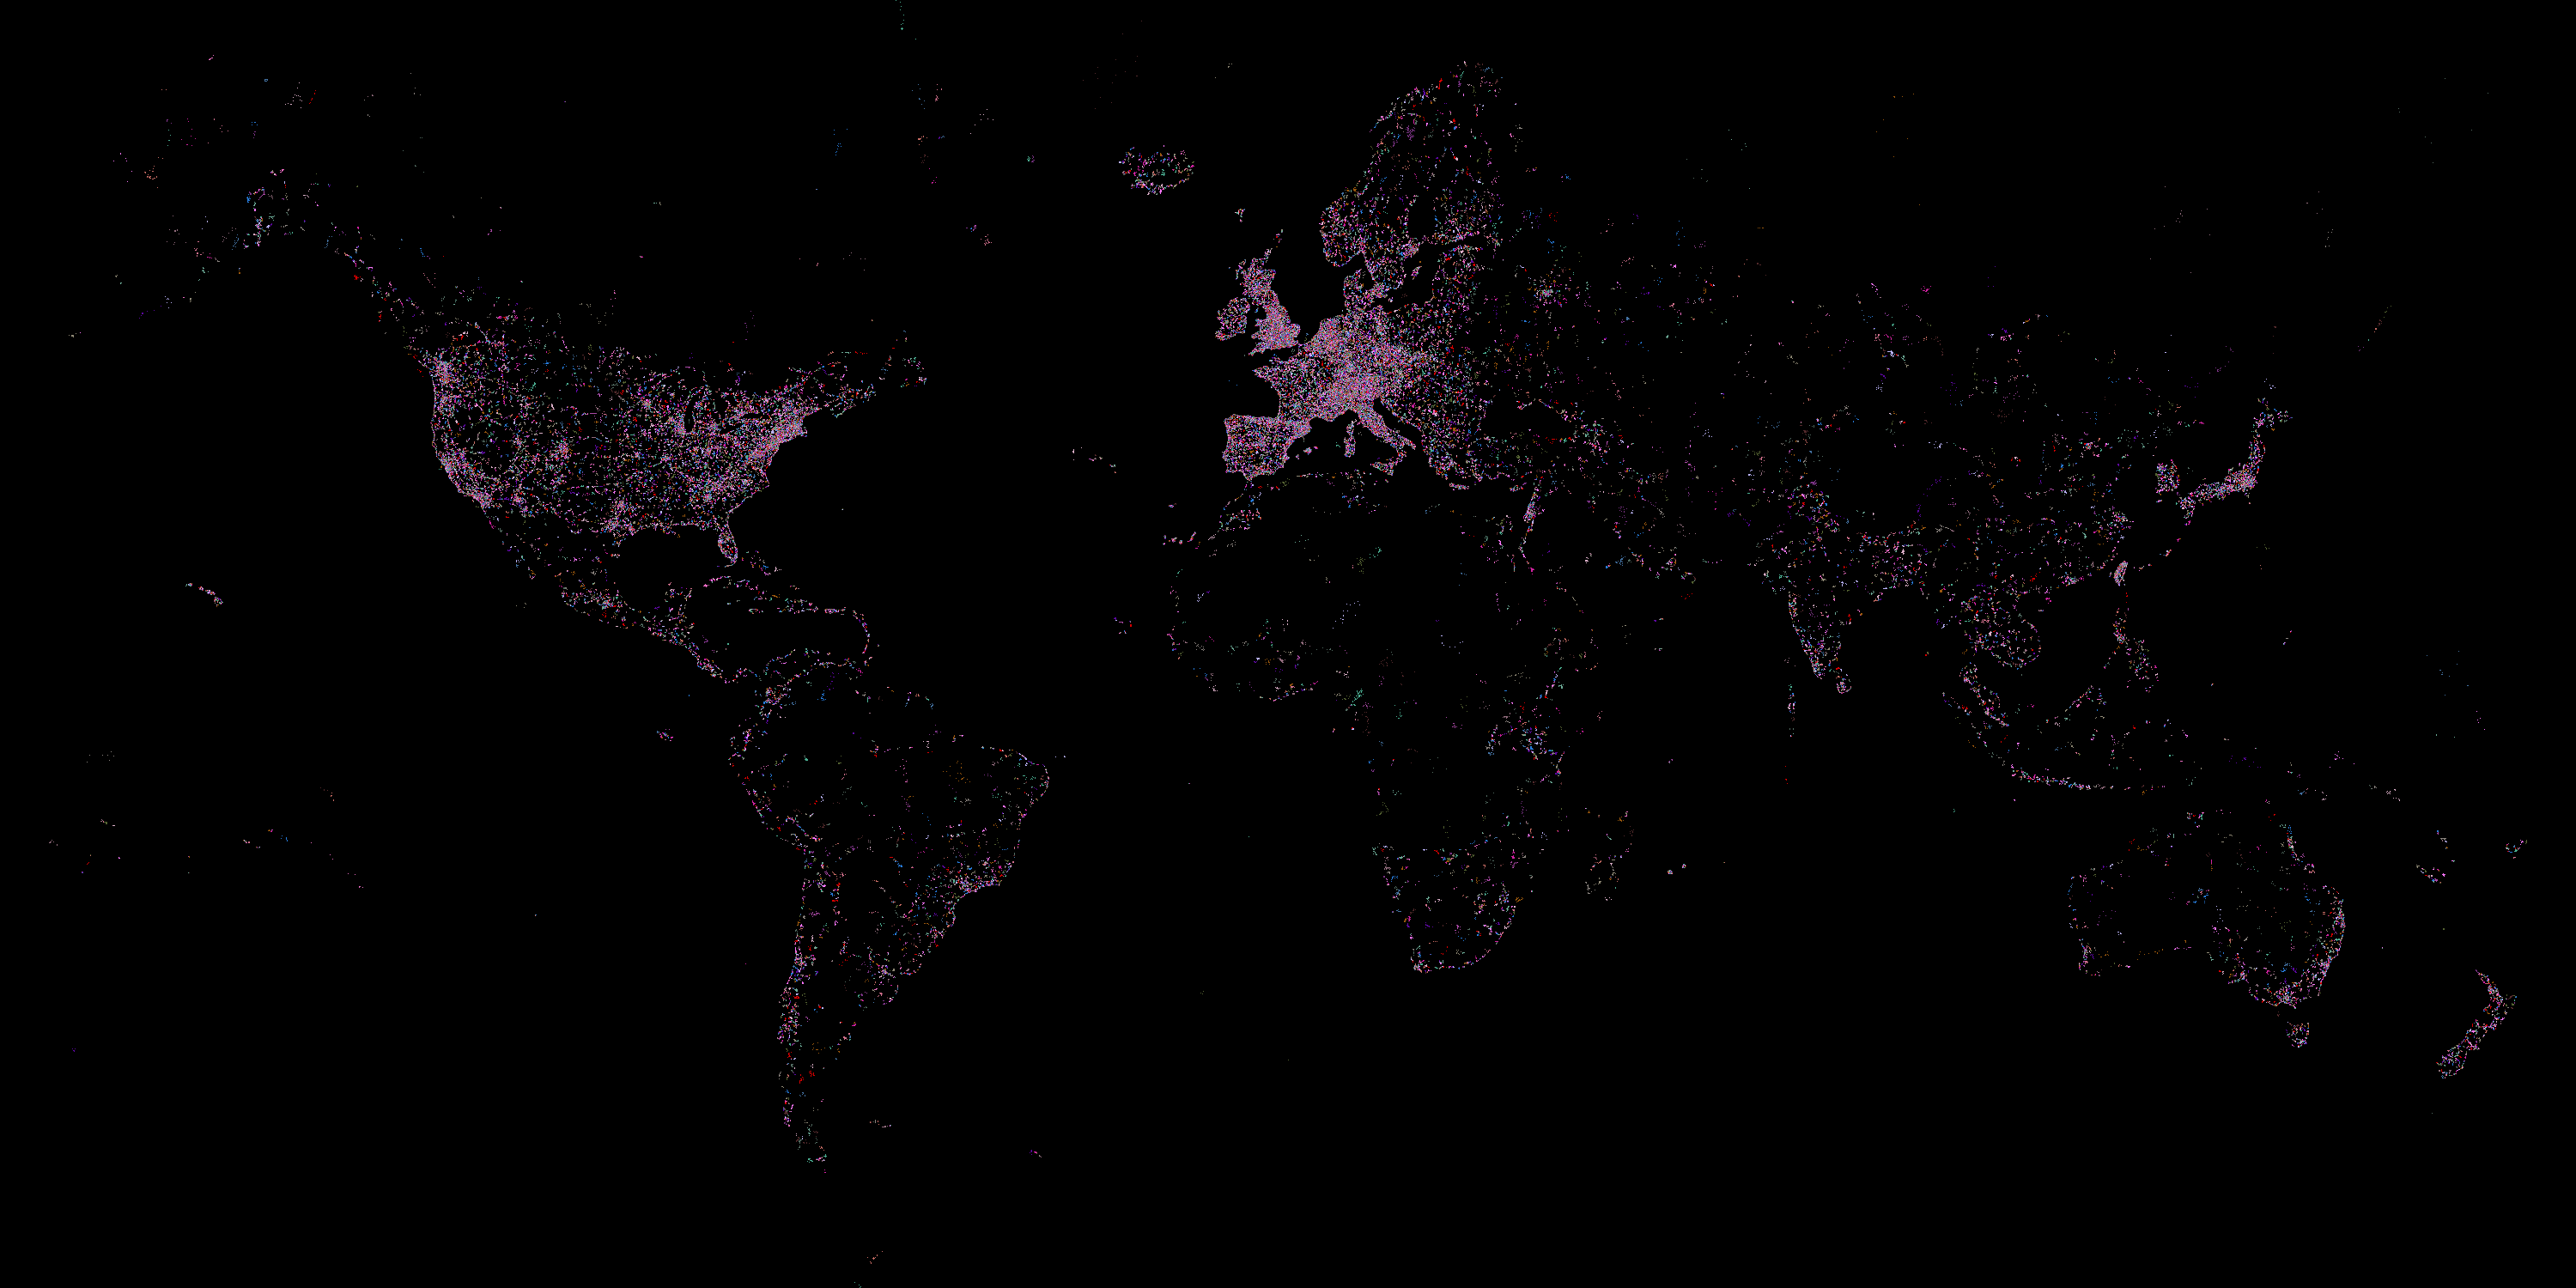

In [67]:
# A more direct approach using datashader's spreading functions
canvas = ds.Canvas(plot_width=3000, plot_height=1500, x_range=x_range, y_range=y_range)

# First, get separate aggregations for each category
aggregations = {}
for cat in reduced_clusters['cluster'].cat.categories:
    cat_df = reduced_clusters[reduced_clusters['cluster'] == cat]
    if len(cat_df) > 0:
        aggregations[cat] = canvas.points(cat_df, 'x', 'y')

# Now combine them with the winner-takes-all approach
import numpy as np
import xarray as xr

# Create a blank canvas for the result
result = xr.zeros_like(aggregations[list(aggregations.keys())[0]])

# Create a mask array to track where we have data
has_data = xr.zeros_like(result, dtype=bool)

# For each pixel, find the category with the highest count
cat_indices = xr.zeros_like(result, dtype=np.int8)

for i, (cat, agg) in enumerate(aggregations.items()):
    # Where this category has more points than what's currently stored
    mask = (agg > result).values
    
    # Update the result and category index where this category wins
    result.values[mask] = agg.values[mask]
    cat_indices.values[mask] = i  # +1 to avoid 0 (background)
    has_data.values[mask] = True

# Only shade areas where we have data
masked_indices = cat_indices.where(has_data)

# Shade with the colormap
img = tf.shade(masked_indices, cmap=cc.glasbey_dark, how='eq_hist', min_alpha=50)

# Set background for the transparent areas
img = tf.set_background(img, color='black')
img.to_pil().save("colored_clusters.png")
display(img.to_pil())

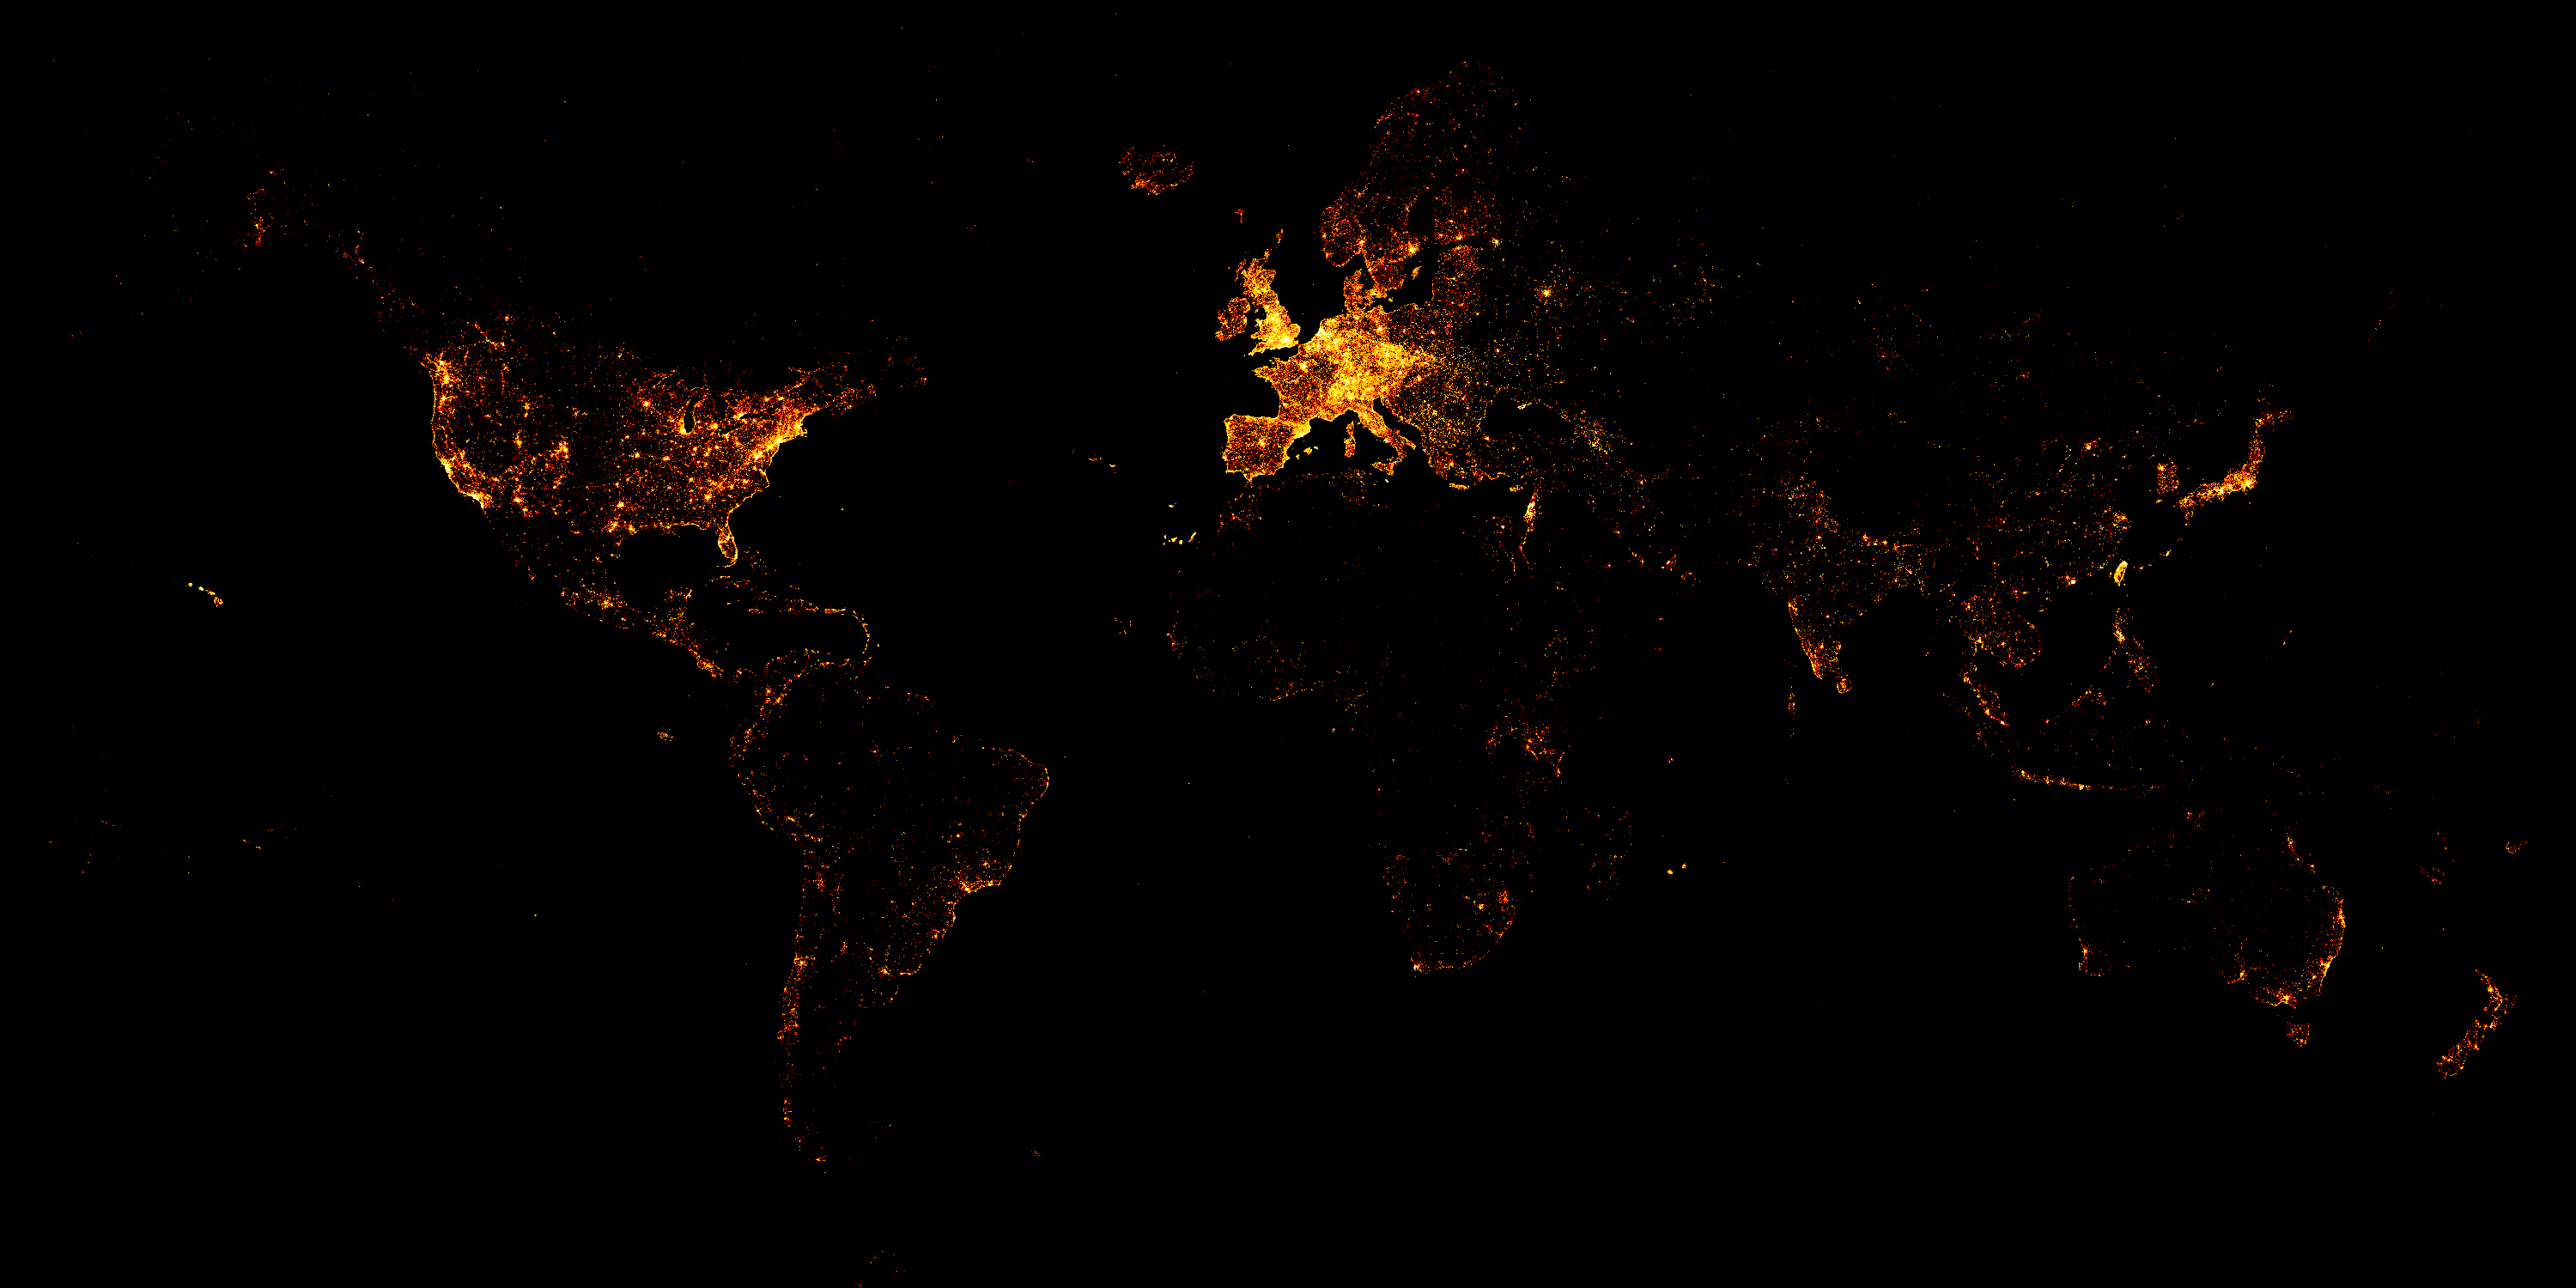

In [34]:
canvas = ds.Canvas(plot_width=3000, plot_height=1500, x_range=x_range, y_range=y_range)

agg_density = canvas.points(pandas_df, 'x', 'y', ds.count())
img_density = tf.shade(agg_density, cmap=cc.fire, how='eq_hist', min_alpha=50, alpha=255)
img_density = tf.set_background(img_density, color='black')
img_density.to_pil().save('data_density.png')
display(img_density.to_pil())